In [1]:
# import libraries
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
import pickle 
import xarray as xr
import matplotlib.colors as colors

# for mapping
import cartopy.crs as ccrs
# https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html
import cartopy.feature as cft
# BIG issue with cartopy: see here https://github.com/SciTools/cartopy/issues/1325 at @jypeter
# I had to download a bunch of stuff myself and put it in ~/.local/share/cartopy/shapefile/.../...
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
# https://scitools.org.uk/cartopy/docs/v0.15/examples/axes_grid_basic.html
land_110m = cft.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='gray', linewidth=0.5) # continents

In [2]:
# Extract TOC and TOX flux data from Hayes et al., 2021.
TOC_concentration = xr.open_dataset('data/Hayes/TOCConc1degR.nc')
Flux_TOC = xr.open_dataset('data/Hayes/F_TOCMapR3.nc')

# metadata
latHayes = np.array(TOC_concentration['Latitude'])
lonHayes = np.array(TOC_concentration['Longitude'])
TOC_conc = TOC_concentration['TOCConcMap']
FTOC = np.array(Flux_TOC['TOCMap'])*10 # gC m-2 yr-1
FTOC = np.concatenate((FTOC[:,180:], FTOC[:,:180]), axis = 1) # centered on Europe
lonHayes = TOC_concentration['Longitude'] - 180

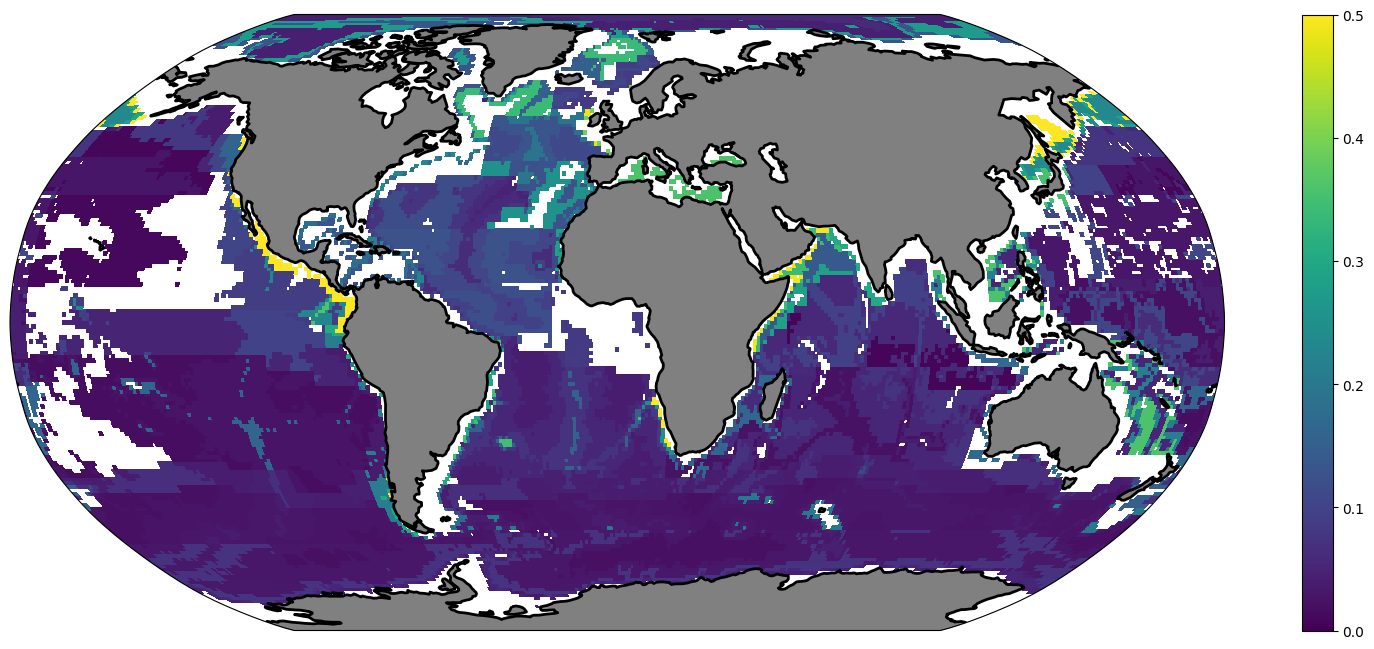

In [3]:
# plot TOC fluxes
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, FTOC, shading = 'auto', vmin = 0, vmax = 0.5, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [4]:
# compute mask where FTOC values are not defined (= missing data)
mask_FTOC = np.where(np.isnan(FTOC), 1, FTOC) 
mask_FTOC = np.where(mask_FTOC < 1, np.nan, mask_FTOC)

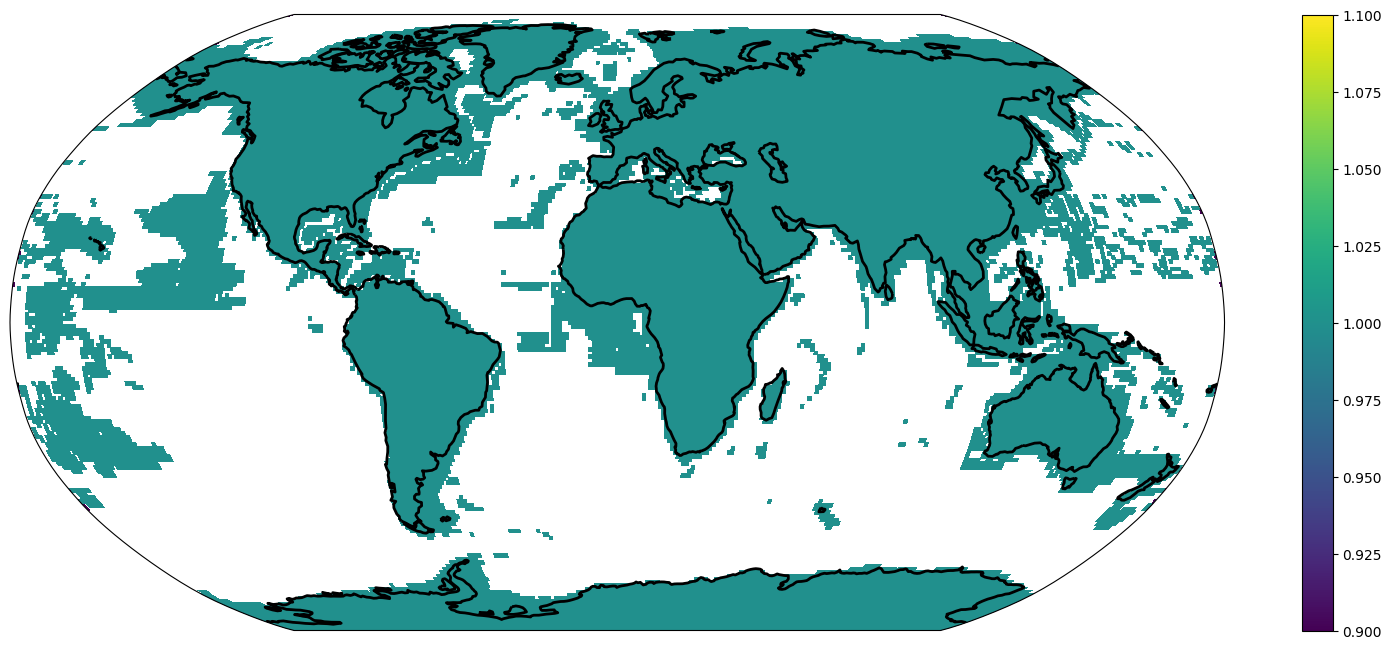

In [5]:
# plot mask (1 = no FTOC data)
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
#ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, mask_FTOC, shading = 'auto', vmin = None, vmax = None, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [6]:
def add_matrix(A,B):
    """
    Function that deals with the issue of matrix addition with NaN (np.nansum(np.nan) == 0)
    This could potentially bias some average so it is important to be cautious when adding arrays with NaN.
    """
    matrix = np.where(np.isnan(A), B, A + np.nan_to_num(B))  
    return(matrix)

# Bathymetry from NOAA (you need to execute the script 03_get_bathy_from_NOAA at this point)

In [7]:
# get bathymetry field from NOAA
noaa_bathy = pd.read_csv('data/Bathymetry/marmap_coord_-180;-90;180;90_res_60.csv')
noaa_bathy['V1'] = noaa_bathy['V1'].apply(lambda x: np.round(x))
bat = np.array(noaa_bathy['V3']).reshape(FTOC.shape)
bat = np.where(bat>=0, np.nan, bat) 
bat = bat[::-1,:]
bat = bat * -1

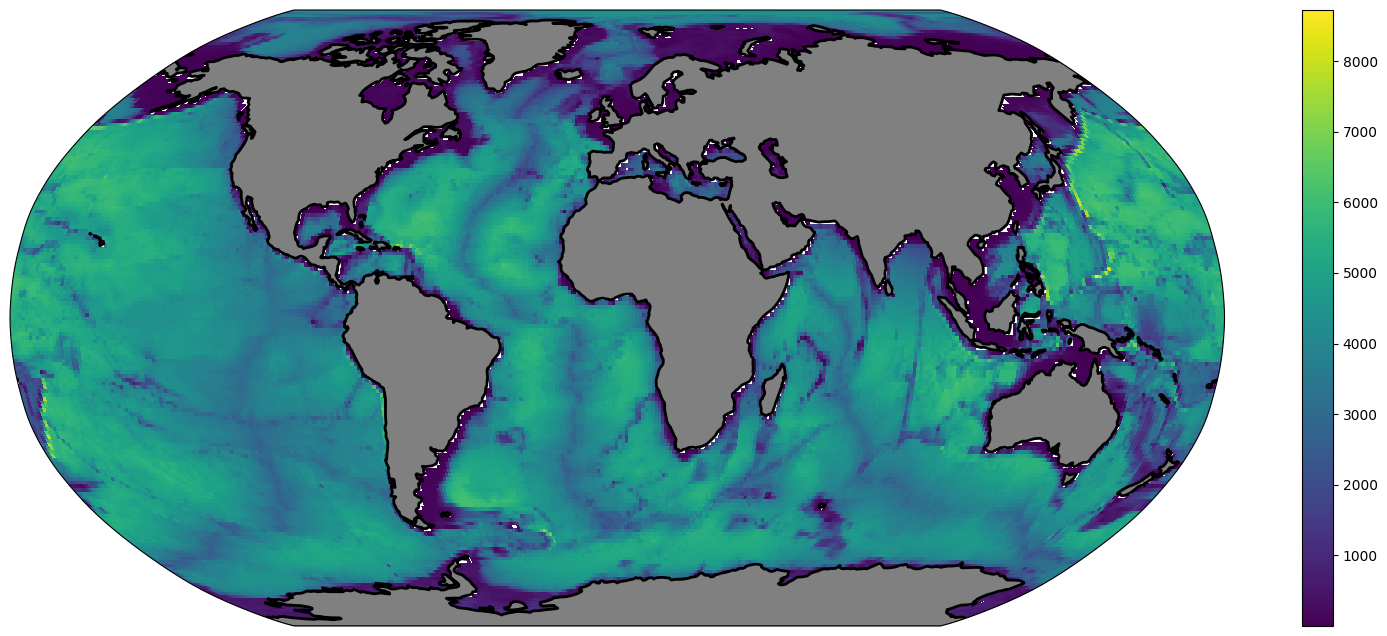

In [8]:
# plot bathymetry
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, bat, shading = 'auto', vmin = None, vmax = None, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [9]:
# mask bathymetry where depth < 1000 m because Hayes does not have POC flux data between 0 and 1000 m
mask_bat = np.where(bat<1000, np.nan, bat) 

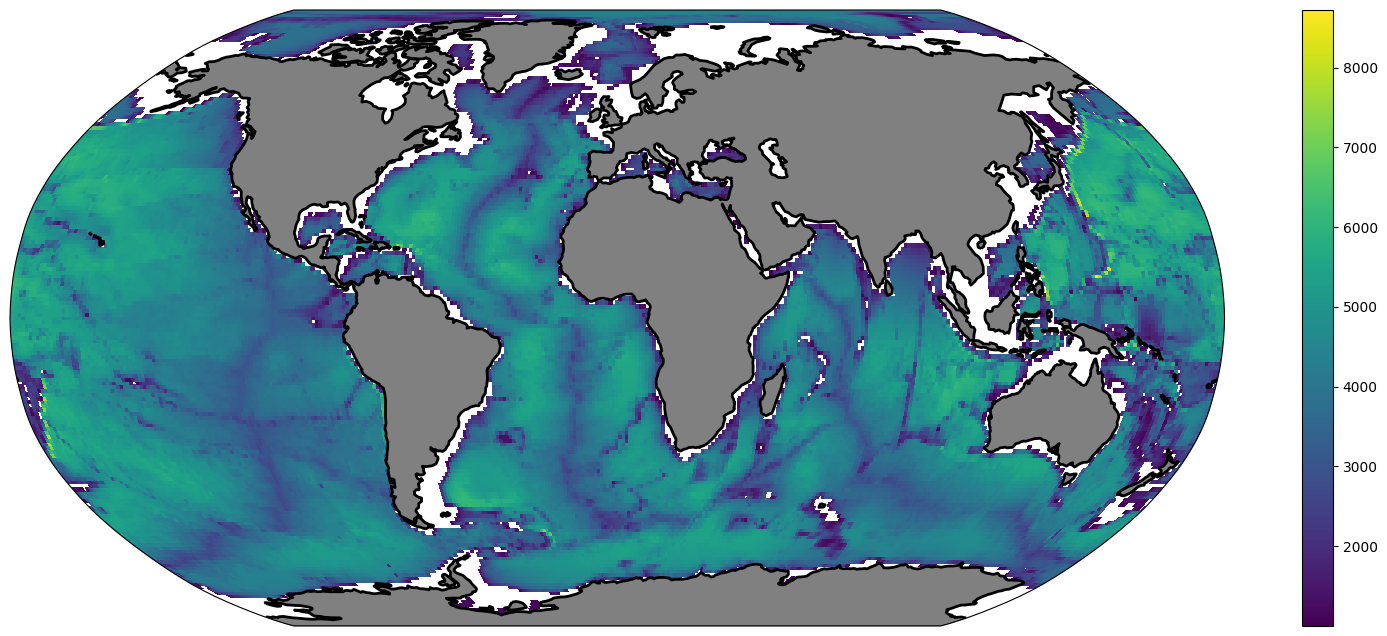

In [10]:
# show bathymetry > 1000 m
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, mask_bat, shading = 'auto', vmin = None, vmax = None, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

# So far, we have two issues.

- 1: We have missing sediment flux data (see mask FTOC)
- 2: and we don't have FTOC data for pixels where the bathymetry does not exceed 1000 m.

To fill those gaps, I am gonna extract the maximum depth used in the model of Devries et al., 2017 (= zmax).

In [11]:
tim_data = scipy.io.loadmat('data/Devries/F100.mat') 
f100 = tim_data['F100'] # # f100 (dimensionless) is the percentage of sequestered carbon
latT = np.concatenate(tim_data['lat'])
lonT = np.concatenate(tim_data['lon'])
depthT = np.concatenate(tim_data['depth']) # units = m

# Tim's longitude are eastward so from 0 to 360. I want -180 to 180 to fit my grid hence we do a bit translation.
f100 = np.concatenate((f100[:,90:,:], f100[:,:90,:]), axis = 1)
lonT = np.linspace(-179, 179, 180)

# replace 1 by 0 in Tim's first layer because it should not be 100% of sequestration at the surface (in his case, 4 meters).
f100[:,:,0] = np.where(f100[:,:,0] == 1 , 0, f100[:,:,0])

# compute max depth before reaching the sediment
zmax = np.zeros(f100[:,:,0].shape)

# NOTE : I did not make the distinction between oceans and inland waters. However, f100 is only defined in 'ocean'
# waters so the problem goes away by itself. We should then see the 'ocean' points at depth < 100 m in white
# on the maps

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        if (all(np.isnan(tmp)) == False) & (np.isnan(np.sum(tmp))): # so we are not on a 'land' pixel or on a deep point (with data at 5581 m)
            index = np.argwhere(np.isnan(tmp))[0][0]
            zmax[r,c] = depthT[index-1]
        elif np.isnan(np.sum(tmp)) == False: # we are in the case of the 5581m layer
            zmax[r,c] = np.max(depthT)
        else:
            zmax[r,c] = np.nan

# mask pixels where Zmax < 100m
zmax_with_shallow_pixels = np.copy(zmax)
zmax = np.where(zmax<100, np.nan, zmax) 

# create mask
mask = np.where(zmax > 0.0, 1.0, zmax) # it masks the pixel < 100 m depth and some inland seas 
#mask = np.where(mask != 1.0, 0.0, mask) # was used to check if mask was equal to maskST -> yes

# check if previous step is ok
# np.argwhere(zmax == np.nanmax(zmax))
# np.argwhere(~np.isnan(f100[:,:,47]))

# ok it gives the same output

In [12]:
# interpolate zmax on FTOC shape
points = (latT, lonT)
values = zmax

zmax_bis = []
for i, lat in enumerate(latHayes):
    for j, lon in enumerate(lonHayes):
        point = np.array([lat,lon])
        try:
            tmp = float(interpn(points, values, point, method = 'nearest'))
            zmax_bis.append(tmp)
        except:
            tmp = np.nan
            zmax_bis.append(tmp)
            
zmax_bis = np.array(zmax_bis).reshape(FTOC.shape)

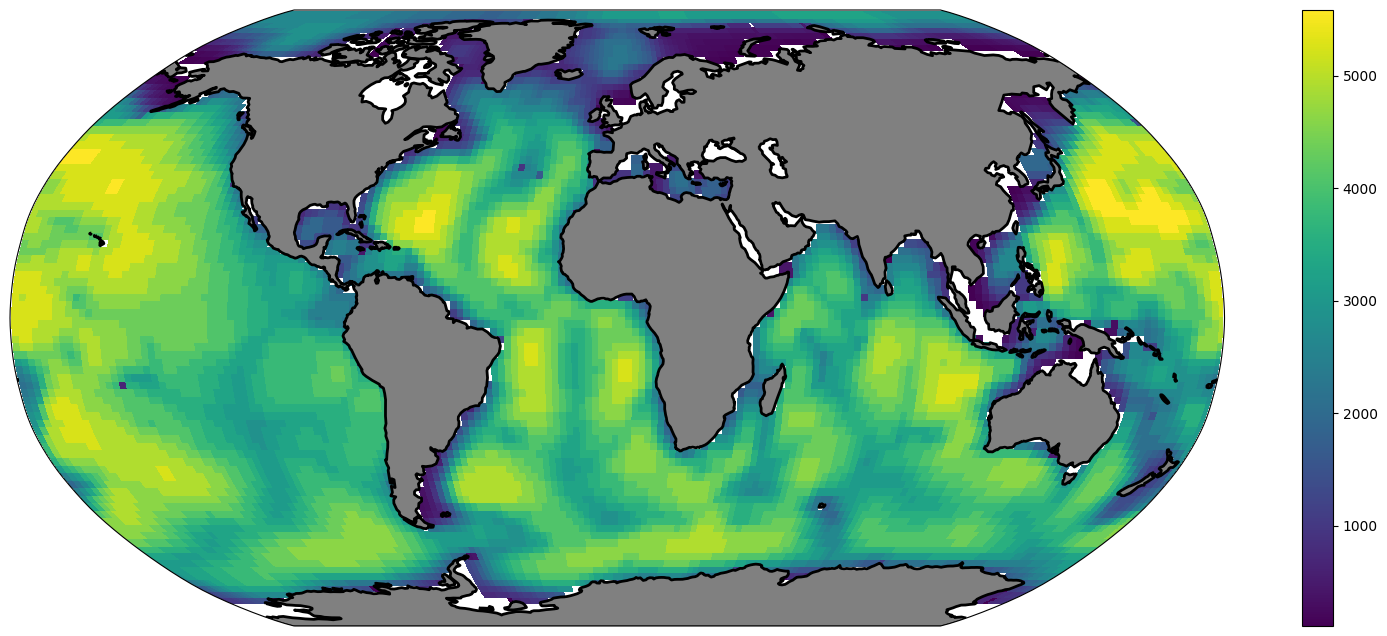

In [13]:
# plot zmax
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, zmax_bis, shading = 'auto', vmin = None, vmax = None, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

# OK. Let's continue and prepare some data

In [14]:
# check mask bathy and FTOC values, save it to be read with R later on.
tmp = pd.DataFrame({'x':FTOC.flatten(), 'bathy':mask_bat.flatten()})
tmp.to_csv('data/Bathymetry/check_bathy.csv')

In [15]:
# mask (without continent) where 1 indicates the oceanic pixels where the bathymetry is below 1000 m.
mask_FTOC = np.where(np.isnan(FTOC), 1, FTOC) 
mask_FTOC = np.where(mask_FTOC < 1, np.nan, mask_FTOC)
mask_FTOC_2 = mask_FTOC * zmax_bis/zmax_bis

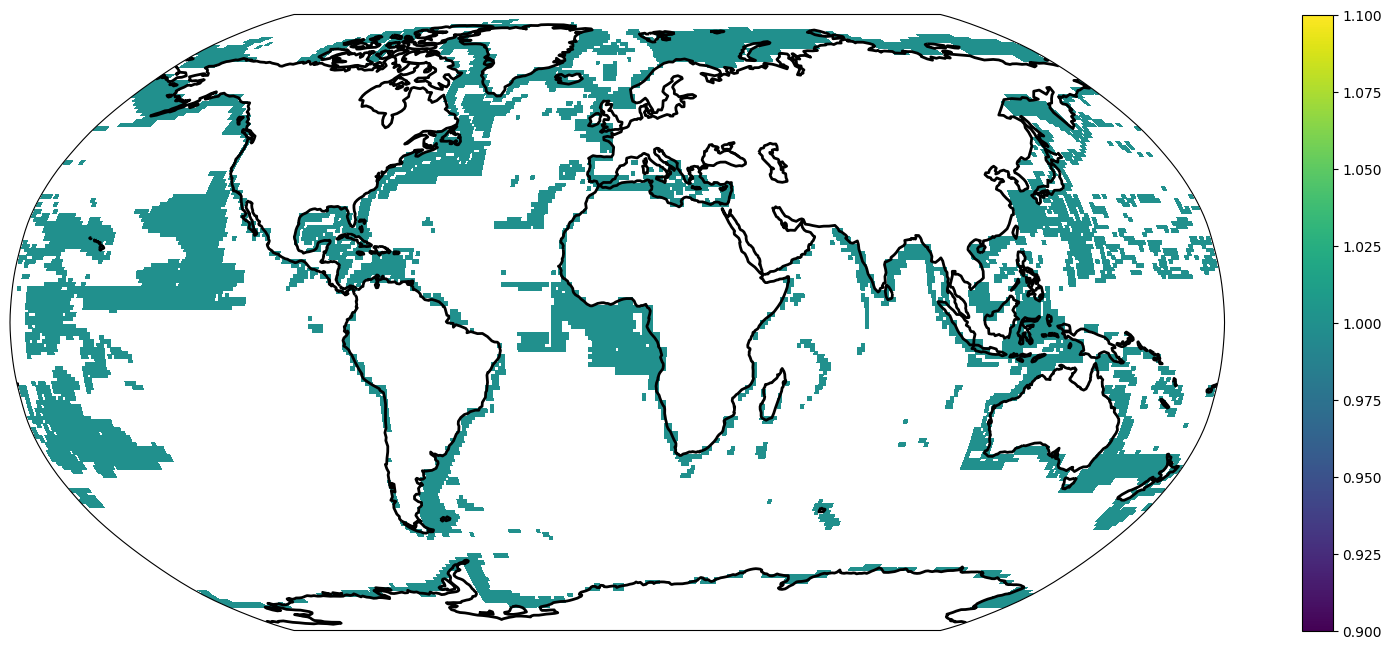

In [16]:
# plot new mask
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
#ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
#p = ax.scatter(sediment['longitude'], sediment['latitude'], c = sediment['TOC'], transform=ccrs.PlateCarree(), vmin = 0, vmax = None)
#p = ax.pcolormesh(lon, lat, TOC_conc, shading = 'auto', vmin = 0, vmax = None, transform=ccrs.PlateCarree())
p = ax.pcolormesh(lonHayes, latHayes, mask_FTOC_2, shading = 'auto', vmin = None, vmax = None, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [17]:
# return pixels to fill. Here I am saving a file where I combine the pixel that do not have sediment flux data because Hayes did not have them or pixels that do not have sediment data because they are below 1000 m. 
# Note that this ugly code could have been simplified though I needed to remove the continent pixels (that is why I used zmax). I did not have a ocean/land mask. I could have done it with the NOAA bathymetry file but meh. At least, I have the good resolution
# for what's next.
tmp2 = pd.DataFrame({'mask_FTOC':mask_FTOC_2.flatten(), 'bathy':bat.flatten()})
tmp2.to_csv('data/Bathymetry/fill_missing_pixels.csv')

# OK now, go to 04_fill_missing_Hayes_pixels.R

In [18]:
# read filled pixels
filled_pixels = pd.read_csv('data/Bathymetry/missing_pixels_filled.csv')

In [19]:
filled_pixels = np.array(filled_pixels['mask_FTOC'])
filled_pixels = filled_pixels.reshape(FTOC.shape)

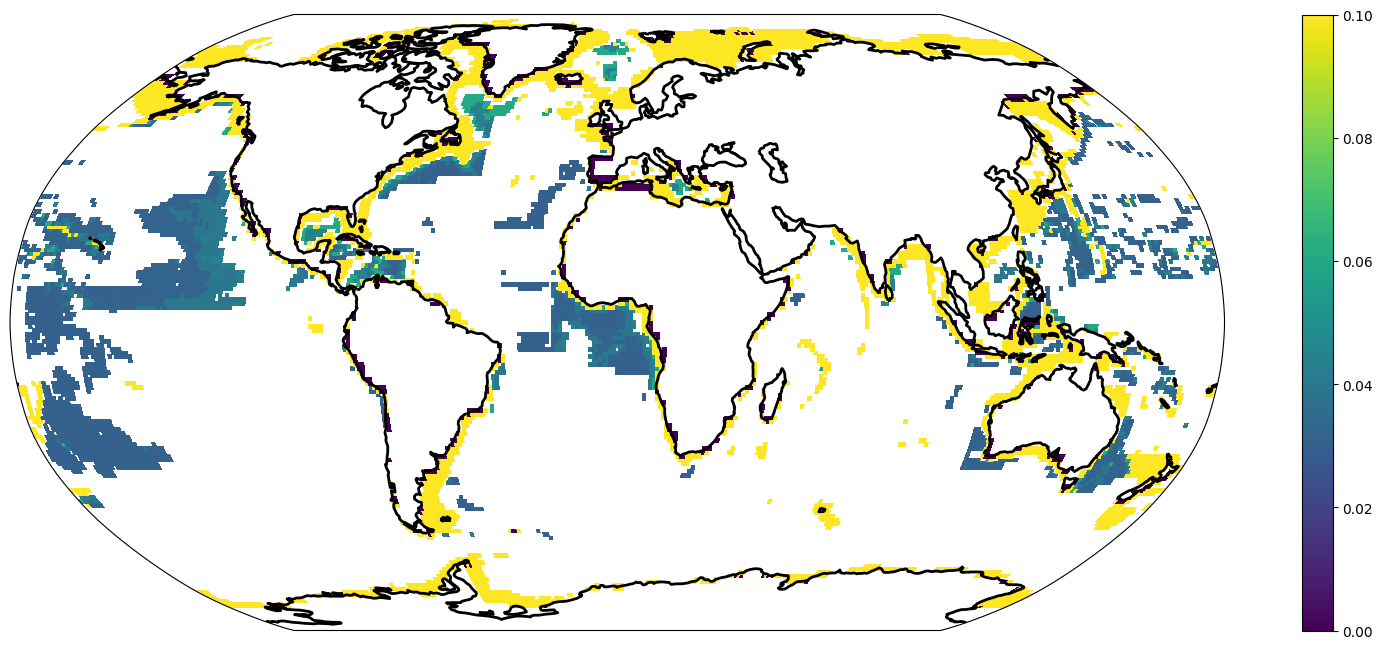

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
#ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, filled_pixels, shading = 'auto', vmin = 0, vmax = 0.1, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [21]:
# fill the gaps in FTOC with the filled pixels
all_data = add_matrix(FTOC,filled_pixels)

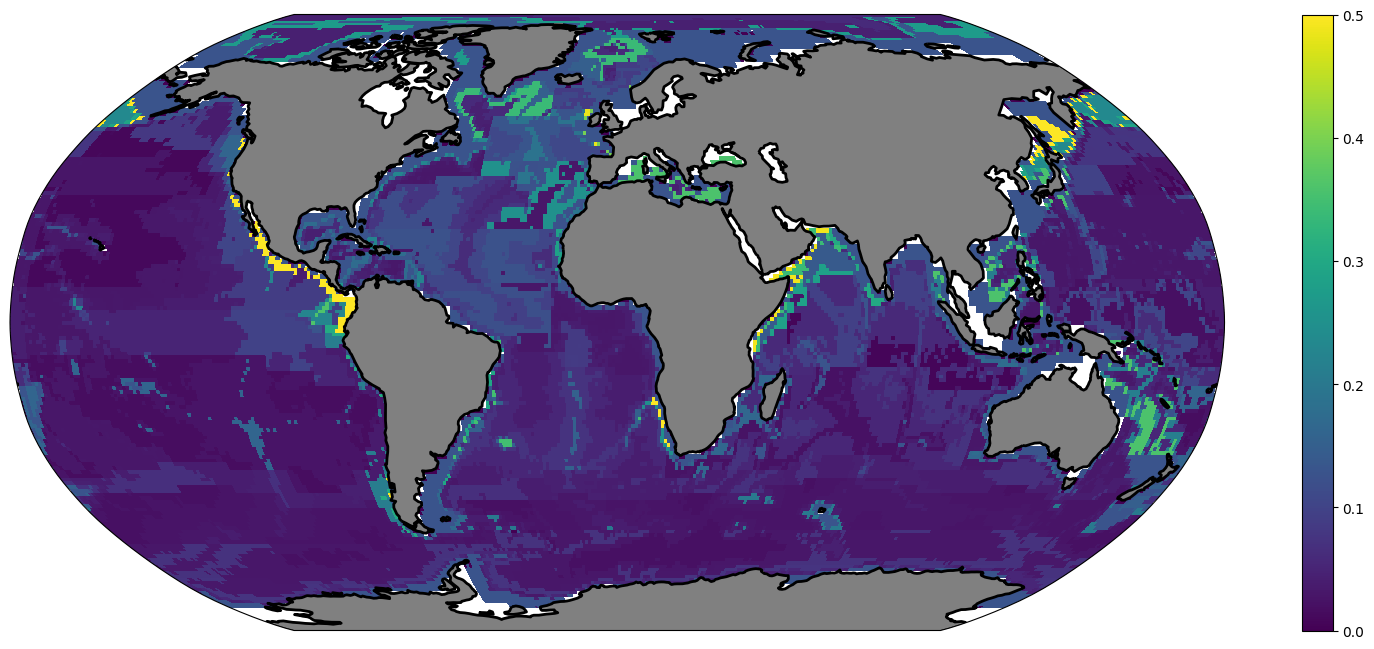

In [22]:
# plot all (initial + extrapolated) sediment data
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonHayes, latHayes, all_data, shading = 'auto', vmin = None, vmax = 0.5, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [23]:
# interp on zmax for main python file --> because we need to use this on the shape of Devries's grid file
points = (latHayes, lonHayes)
values = all_data

Fsedim = []
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        point = np.array([lat,lon])
        try:
            tmp = float(interpn(points, values, point, method = 'nearest'))
            Fsedim.append(tmp)
        except:
            tmp = np.nan
            Fsedim.append(tmp)
            
Fsedim = np.array(Fsedim).reshape(zmax.shape)

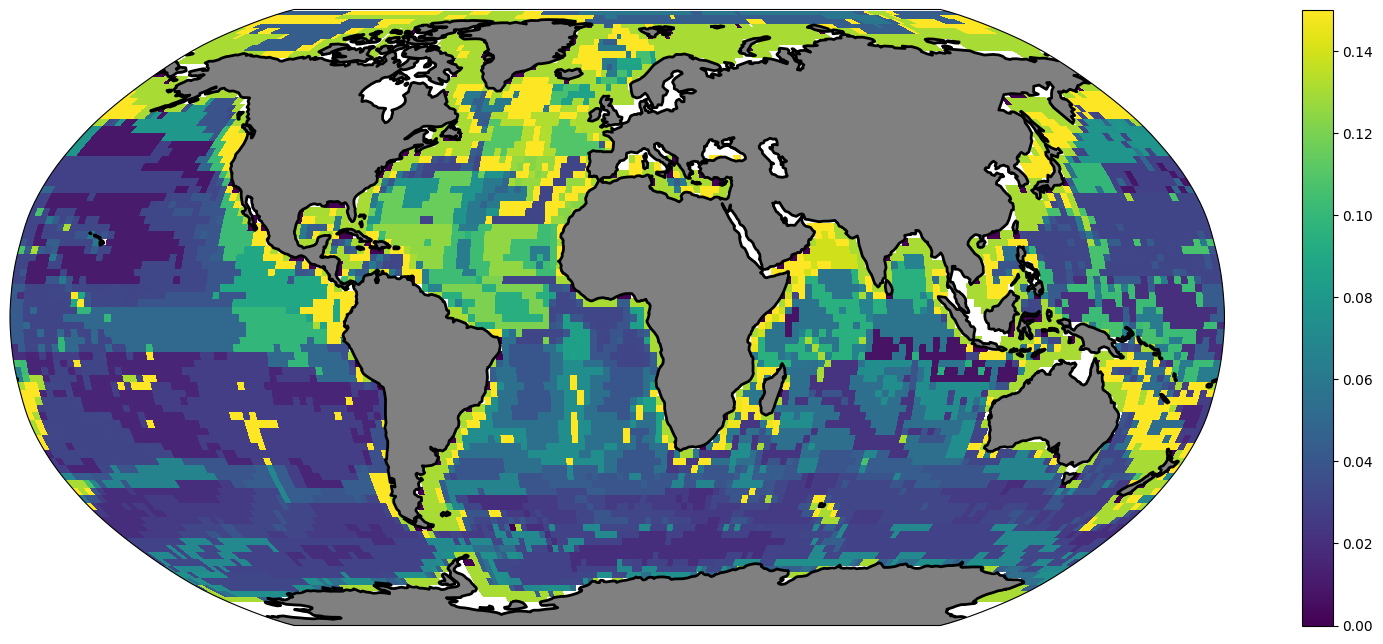

In [24]:
# plot newly gridded product
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.add_feature(land_110m)
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
p = ax.pcolormesh(lonT, latT, Fsedim, shading = 'auto', vmin = None, vmax = 0.15, transform=ccrs.PlateCarree())
cbar = plt.colorbar(p)
plt.show()

In [25]:
# save sediment data
np.save('data/Hayes/Fsedim.npy', Fsedim)